In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
plt.rc('font', family='Arial')

from qtrendutils import linfit_utils as linfit
from qtrendutils import shapefile_utils as shp
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import lineplot_utils as lineplot
from qtrendutils import calendar_utils as cal
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import sys

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
### ISD
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
isd_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
isd_sw_lons = isd_vp_swstat.lons ; isd_sw_lats = isd_vp_swstat.lats ; isd_sw_wgts = isd_vp_swstat.area_weights
isd_vp_swstat = isd_vp_swstat.drop_vars(['lons','lats', 'area_weights'])

# compute the seasonal cycle
isd_sw_seascyc = isd_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_sw_deseas = isd_vp_swstat.groupby('time.month') - isd_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
isd_sw_seascyc = isd_sw_seascyc.rename({"month":"time"})
isd_sw_seascyc['time'] = isd_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_sw_seascyc_am = cal.calcannualmean(isd_sw_seascyc)

# annual average of deseasonzlied anomalies
isd_sw_deseas_am = cal.calcannualmean(isd_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_sw_seascyc_am = isd_sw_seascyc_am.expand_dims({"otheryrs":isd_sw_deseas_am.year.size})
isd_sw_seascyc_am = isd_sw_seascyc_am.stack(z=("year","otheryrs"))
isd_sw_seascyc_am = isd_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
isd_sw_seascyc_am = isd_sw_seascyc_am.assign_coords({'year':isd_sw_deseas_am.year})

# expand out the monthly seasonal cycle to have the appropriate length
isd_sw_seascyc = isd_sw_seascyc.expand_dims({"otheryrs":isd_sw_deseas_am.year.size}, axis=0)
isd_sw_seascyc = isd_sw_seascyc.stack(z=("otheryrs","time"))
isd_sw_seascyc = isd_sw_seascyc.reset_index('z', drop=True).rename(z='time')
isd_sw_seascyc = isd_sw_seascyc.assign_coords({'time':isd_vp_swstat.time})


# add back in the annual average climatology
isd_sw_am = isd_sw_seascyc_am + isd_sw_deseas_am
isd_sw_monthly = isd_sw_seascyc + isd_sw_deseas

isd_sw_am = xr.merge([isd_sw_am, isd_sw_lons, isd_sw_lats, isd_sw_wgts]) 
isd_sw_monthly = xr.merge([isd_sw_monthly, isd_sw_wgts])

# now take the average over stations
isd_vp_sw_am = (isd_sw_am*isd_sw_am.area_weights).sum('station') / np.sum(isd_sw_am.area_weights)
isd_vp_sw_am = isd_vp_sw_am.drop_vars(['lons','lats','area_weights'])

# take the average over stations for the monthly deseasonalize for calculating monthly trends
isd_vp_sw_monthly_values = (isd_sw_monthly*isd_sw_monthly.area_weights).sum('station', skipna=True) / np.sum(isd_sw_monthly.area_weights)

isd_vp_sw_am_to2019 = isd_vp_sw_am.sel(year=slice(1980,2019))


In [4]:
### HadISDH
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
hadisdh_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
hadisdh_sw_lons = hadisdh_vp_swstat.lon ; hadisdh_sw_lats = hadisdh_vp_swstat.lat ; hadisdh_sw_wgts = hadisdh_vp_swstat.area_weights
hadisdh_vp_swstat = hadisdh_vp_swstat.drop_vars(['lon','lat','area_weights'])

# compute the seasonal cycle
hadisdh_sw_seascyc = hadisdh_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_sw_deseas = hadisdh_vp_swstat.groupby('time.month') - hadisdh_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
hadisdh_sw_seascyc = hadisdh_sw_seascyc.rename({"month":"time"})
hadisdh_sw_seascyc['time'] = hadisdh_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_sw_seascyc_am = cal.calcannualmean(hadisdh_sw_seascyc)

# annual average of deseasonzlied anomalies
hadisdh_sw_deseas_am = cal.calcannualmean(hadisdh_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size})
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.assign_coords({'year':hadisdh_sw_deseas_am.year})

# expand out the monthly seasonal cycle to have the approriate length
hadisdh_sw_seascyc = hadisdh_sw_seascyc.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size}, axis=0)
hadisdh_sw_seascyc = hadisdh_sw_seascyc.stack(z=("otheryrs","time"))
hadisdh_sw_seascyc = hadisdh_sw_seascyc.reset_index('z', drop=True).rename(z='time')
hadisdh_sw_seascyc = hadisdh_sw_seascyc.assign_coords({'time':hadisdh_vp_swstat.time})

# add back in the annual average climatology
hadisdh_sw_am = hadisdh_sw_seascyc_am + hadisdh_sw_deseas_am
hadisdh_sw_monthly = hadisdh_sw_deseas + hadisdh_sw_seascyc

hadisdh_sw_am = xr.merge([hadisdh_sw_am, hadisdh_sw_lons, hadisdh_sw_lats, hadisdh_sw_wgts]) 
hadisdh_sw_monthly = xr.merge([hadisdh_sw_monthly, hadisdh_sw_wgts])

# now take the average over stations
hadisdh_vp_sw_am = (hadisdh_sw_am*hadisdh_sw_am.area_weights).sum('station') / np.sum(hadisdh_sw_am.area_weights)

# take the average over stations for the monthly deseasonalized for calculating monthly trends
hadisdh_vp_sw_monthly_values = (hadisdh_sw_monthly*hadisdh_sw_monthly.area_weights).sum('station', skipna=True) / np.sum(hadisdh_sw_am.area_weights)

hadisdh_vp_sw_am = hadisdh_vp_sw_am.drop_vars(['lon','lat','area_weights'])
#hadisdh_vp_sw_monthly_values = hadisdh_vp_sw_monthly_values.drop_vars(['lon','lat','area_weights'])

In [5]:
cmip6info = pd.read_csv("/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv")
models = cmip6info['Model']
nmems = cmip6info['Nmem']
nmemmax = np.max(cmip6info['Nmem'])
nmemscmip6 = nmems


basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
era5_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ERA5_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
cmip6_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_CMIP6_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
lens2_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_LENS2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
goga2_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_GOGA2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
#isd_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc').sel(time=slice("1980-01-01","2020-12-31"))
best_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_BEST_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))

era5_vp_sw_am = era5_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
cmip6_vp_sw_am = cmip6_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
lens2_vp_sw_am = lens2_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
goga2_vp_sw_am = goga2_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
#isd_vp_sw_am = isd_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))
best_vp_sw_am = best_vp_sw.groupby('time.year').mean('time').sel(year=slice(1980,2020))

era5_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_sw_am, vectorize=True, input_core_dims=[['year']])*era5_vp_sw_am.year.size
cmip6_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_sw_am, vectorize=True, input_core_dims=[['year']])*cmip6_vp_sw_am.year.size
lens2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*lens2_vp_sw_am.year.size
goga2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, goga2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*goga2_vp_sw_am.year.size
isd_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_am, vectorize=True, input_core_dims=[['year']])*isd_vp_sw_am.year.size
hadisdh_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_am, vectorize=True, input_core_dims=[['year']])*hadisdh_vp_sw_am.year.size
best_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, best_vp_sw_am, vectorize=True, input_core_dims=[['year']])*best_vp_sw_am.year.size

nyears = np.int(era5_vp_sw_am.year.size)

In [6]:
#----monthly trends
year = era5_vp_sw.time.dt.year
nyears = era5_vp_sw.time.size/12
era5_vp_sw_monthly = np.array(era5_vp_sw.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
era5_vp_sw_monthly = xr.DataArray(era5_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
era5_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_sw_monthly, vectorize=True, 
                                          input_core_dims=[['year']])*era5_vp_sw_monthly.year.size


isd_vp_sw_monthly = np.array(isd_vp_sw_monthly_values.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
isd_vp_sw_monthly = xr.DataArray(isd_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
isd_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_monthly, vectorize=True,
                                        input_core_dims=[['year']])*isd_vp_sw_monthly.year.size

#isd_vp_sw_monthly = np.array(isd_vp_sw.vp).reshape([np.int(nyears),12])
#year_monthly = np.array(year).reshape([np.int(nyears),12])
#yearvals = year_monthly[:,0]
#isd_vp_sw_monthly = xr.DataArray(isd_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
#isd_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_monthly, vectorize=True,
#                                        input_core_dims=[['year']])*isd_vp_sw_monthly.year.size

hadisdh_vp_sw_monthly = np.array(hadisdh_vp_sw_monthly_values.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
hadisdh_vp_sw_monthly = xr.DataArray(hadisdh_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
hadisdh_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_monthly, vectorize=True,
                                             input_core_dims=[['year']])*hadisdh_vp_sw_monthly.year.size

lens2_vp_sw_monthly = np.array(lens2_vp_sw.vp).reshape([lens2_vp_sw.M.size,np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
lens2_vp_sw_monthly = xr.DataArray(lens2_vp_sw_monthly, dims=['M','year','month'], coords=[lens2_vp_sw.M, yearvals, np.arange(1,13,1)], name='vp')
lens2_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_sw_monthly, vectorize=True,
                                           input_core_dims=[['year']])*lens2_vp_sw_monthly.year.size


cmip6_vp_sw_monthly = np.array(cmip6_vp_sw.vp).reshape([cmip6_vp_sw.model.size, cmip6_vp_sw.member.size, np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
cmip6_vp_sw_monthly = xr.DataArray(cmip6_vp_sw_monthly, dims=['model','member','year','month'], 
                                   coords=[cmip6_vp_sw.model, cmip6_vp_sw.member, yearvals, np.arange(1,13,1)], name='vp')

cmip6_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_sw_monthly, vectorize=True,
                                           input_core_dims=[['year']])*cmip6_vp_sw_monthly.year.size

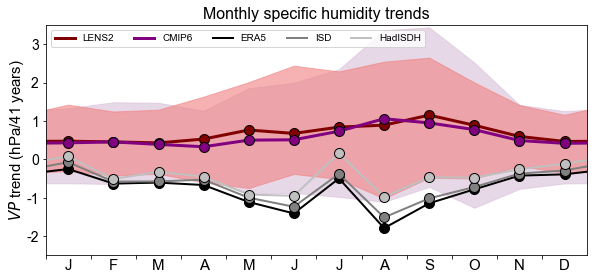

In [11]:
fig = plt.figure(figsize=(16,16))

ax = lineplot.plotlinetime_j2d_monthly(fig, era5_vp_sw_monthly_trend*nan, 0.32,0.79, 0.25,0.45,
                                       'Monthly specific humidity trends',
                                       linecolor='black', ytitle='$VP$ trend (hPa/41 years)',
                                      yrange=[-2.5,3.5],yticks=[-2,-1,0,1,2,3],
                                      yticklabels=['-2','-1','0','1','2','3'], fontsize=16)

    
xvals = np.arange(0,12,1)+0.5
xpad = np.zeros([len(xvals)+2]).astype('float')
xpad[0] = xvals[len(xvals)-1]-12 ; xpad[len(xpad)-1] = xvals[0]+12 ; xpad[1:len(xpad)-1] = xvals

# CMIP6 shading
cmip6_mem_mean = cmip6_vp_sw_monthly_trend.mean('member', skipna=True)
cmip6_mean = cmip6_mem_mean.mean('model')

cmip6stacked = cmip6_vp_sw_monthly_trend.stack(z=("model","member"))
cmip6stacked = cmip6stacked.dropna("z")
mincmip6 = cmip6stacked.min("z")
maxcmip6 = cmip6stacked.max("z")
minpad = np.zeros([len(xvals)+2]).astype('float')
minpad[0] = mincmip6[len(xvals)-1] ; minpad[len(xpad)-1] = mincmip6[0] ; minpad[1:len(xpad)-1] = mincmip6
maxpad = np.zeros([len(xvals)+2]).astype('float')
maxpad[0] = maxcmip6[len(xvals)-1] ; maxpad[len(xpad)-1] = maxcmip6[0] ; maxpad[1:len(xpad)-1] = maxcmip6
ax.fill_between(xpad, minpad, maxpad, color='thistle', alpha=0.6)


# LENS2 shading
minlens2 = lens2_vp_sw_monthly_trend.min('M')
maxlens2 = lens2_vp_sw_monthly_trend.max('M')
minpad = np.zeros([len(xvals)+2]).astype('float')
minpad[0] = minlens2[len(xvals)-1] ; minpad[len(xpad)-1] = minlens2[0] ; minpad[1:len(xpad)-1] = minlens2
maxpad = np.zeros([len(xvals)+2]).astype('float')
maxpad[0] = maxlens2[len(xvals)-1] ; maxpad[len(xpad)-1] = maxlens2[0] ; maxpad[1:len(xpad)-1] = maxlens2
ax.fill_between(xpad, minpad, maxpad, color='lightcoral', alpha=0.6)
# End LENS2 shading

ax = lineplot.oplotlinetime_j2d_monthly(ax, lens2_vp_sw_monthly_trend.mean('M'), linecolor='maroon', label='LENS2', 
                                        linewidth=3, markersize=10)
ax = lineplot.oplotlinetime_j2d_monthly(ax, cmip6_mean, linecolor='purple', label='CMIP6', linewidth=3, markersize=10)


ax = lineplot.oplotlinetime_j2d_monthly(ax, era5_vp_sw_monthly_trend, linecolor='black', label='ERA5', linewidth=2, markersize=10)
ax = lineplot.oplotlinetime_j2d_monthly(ax, isd_vp_sw_monthly_trend, linecolor='gray', label='ISD', linewidth=2, markersize=10)
ax = lineplot.oplotlinetime_j2d_monthly(ax, hadisdh_vp_sw_monthly_trend, linecolor='silver', label='HadISDH', linewidth=2, markersize=10)

ax.legend(loc='upper left', ncol=5)
  
fig.savefig(plotpath+'figS8.pdf', bbox_inches='tight', facecolor='white')
    